# Implementation of Regular VAE and Gaussian(1,2) VAE

     NOTE: THIS CODE WAS USED SOLELY FOR AN INITIAL SANITY CHECK TO TEST THE RESULT OF SAMPLING FROM DIFFERENT DISTRIBUTIONS. THE CODE BELONGS TO JACKSON KANG
     For Gaussian(1,2) and Regular VAE my code works successfully
     However since I was unable to get the Beta(1,1) VAE code to work, I did not proceed beyond the sanity check stage and thus did not code my own VAE

     VAE from "Auto-Encoding Variational Bayes" (2014, D.P. Kingma et. al.)
    
     Kernel-author: Jackson Kang @ Deep-learning Lab. (Handong Global University, S.Korea)
     
     Author-email:  mskang@handong.edu

     python and pytorch version: python=3.7, pytorch=1.3.1

In [1]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [44]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = False
DEVICE = torch.device("cuda" if cuda else "cpu")
#print(DEVICE)

batch_size = 200

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 30

###    Step 1. Load (or download) Dataset

In [45]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

### Step 2. Define our model: Variational AutoEncoder (VAE)

In [18]:
"""
    A simple  implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

In [19]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
        

In [20]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

In [21]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

### Step 3. Define Loss function (reprod. loss) and optimizer

In [23]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

### Step 4. Train Variational AutoEncoder (VAE)

In [24]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  174.41865408819388
	Epoch 2 complete! 	Average Loss:  128.1624060445795
	Epoch 3 complete! 	Average Loss:  116.67543501865087
	Epoch 4 complete! 	Average Loss:  112.89665058626356
	Epoch 5 complete! 	Average Loss:  110.44973541514503
	Epoch 6 complete! 	Average Loss:  108.7840211713533
	Epoch 7 complete! 	Average Loss:  107.47432452525042
	Epoch 8 complete! 	Average Loss:  106.42984528250209
	Epoch 9 complete! 	Average Loss:  105.65318403393677
	Epoch 10 complete! 	Average Loss:  104.91231463246035
	Epoch 11 complete! 	Average Loss:  104.3251713793823
	Epoch 12 complete! 	Average Loss:  103.85005119209099
	Epoch 13 complete! 	Average Loss:  103.465671920649
	Epoch 14 complete! 	Average Loss:  103.06160958368113
	Epoch 15 complete! 	Average Loss:  102.75992585298414
	Epoch 16 complete! 	Average Loss:  102.49220217289232
	Epoch 17 complete! 	Average Loss:  102.20122587124374
	Epoch 18 complete! 	Average Loss:  102.02941665471097
	E

### Step 5. Generate images from test dataset

In [25]:
import matplotlib.pyplot as plt

In [46]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        print((batch_size))
        x_hat, _, _ = model(x)


        break

  0%|          | 0/50 [00:00<?, ?it/s]

200


  0%|          | 0/50 [00:03<?, ?it/s]


In [47]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

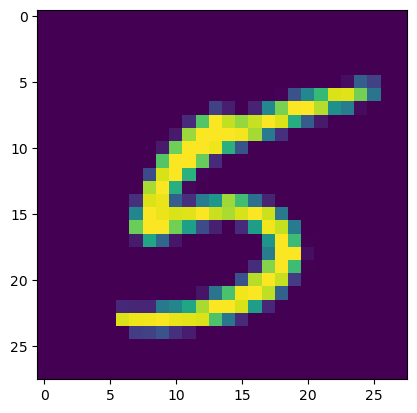

In [48]:
show_image(x, idx=52)

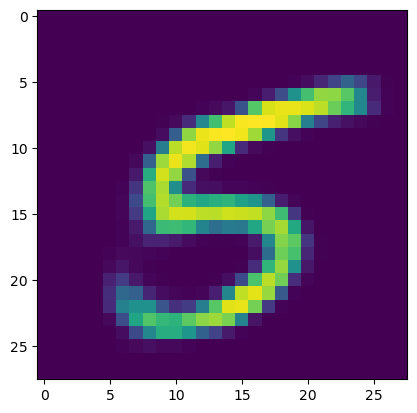

: 

In [60]:
show_image(x_hat, idx=52)

## Repeating with Gaussian(1,2)

In [53]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - np.log(2) - ((mean-1).pow(2))/2 - log_var.exp()/2)

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

In [54]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    

Start training VAE...
	Epoch 1 complete! 	Average Loss:  102.45285887855351
	Epoch 2 complete! 	Average Loss:  99.56454202811454
	Epoch 3 complete! 	Average Loss:  99.2380981526965
	Epoch 4 complete! 	Average Loss:  99.14616201139214
	Epoch 5 complete! 	Average Loss:  98.94644034803511
	Epoch 6 complete! 	Average Loss:  98.89494156955476
	Epoch 7 complete! 	Average Loss:  98.82072445260242
	Epoch 8 complete! 	Average Loss:  98.66209712714256
	Epoch 9 complete! 	Average Loss:  98.54344951923076
	Epoch 10 complete! 	Average Loss:  98.56677002769649
	Epoch 11 complete! 	Average Loss:  98.44542972016096
	Epoch 12 complete! 	Average Loss:  98.48417527827132
	Epoch 13 complete! 	Average Loss:  98.33687003553511
	Epoch 14 complete! 	Average Loss:  98.24360374425167
	Epoch 15 complete! 	Average Loss:  98.19570629311245
	Epoch 16 complete! 	Average Loss:  98.15417171822743
	Epoch 17 complete! 	Average Loss:  98.11964977659908
	Epoch 18 complete! 	Average Loss:  98.14807757629599
	Epoch 19 compl

In [55]:
import matplotlib.pyplot as plt
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        print((batch_size))
        x_hat, _, _ = model(x)


        break

  0%|          | 0/50 [00:00<?, ?it/s]

200


  0%|          | 0/50 [00:04<?, ?it/s]


In [56]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

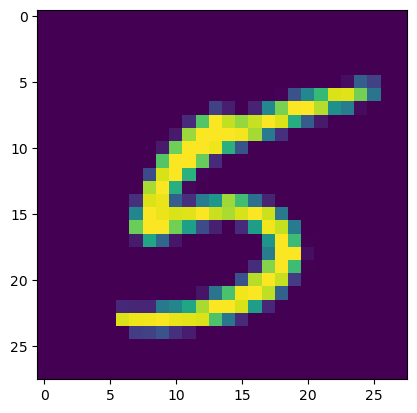

In [58]:
show_image(x, idx=52)

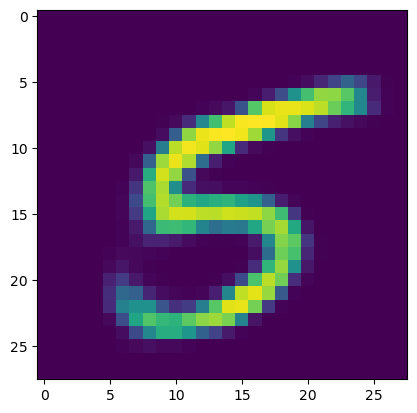

In [59]:
show_image(x_hat, idx=52)